In [3]:
# train_bow_xgb.py

import re
import pickle
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# Prepare stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# Load and filter hoax news data
hoax = pd.read_csv(
    "../Dataset/hoax_news.csv",
    usecols=["Title", "Narasi", "category"]
).dropna(subset=["Title", "Narasi", "category"])
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"

# Load real news data
real = pd.read_csv(
    "../Dataset/detik_news.csv",
    usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# Remove outliers from hoax set based on length
for column in ["title", "body"]:
    lengths = hoax[column].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# Balance classes by downsampling to the smaller class size
df = pd.concat([hoax, real], ignore_index=True)
min_count = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda grp: grp.sample(min_count, random_state=42)
)

# Split into training, validation, and test sets (70/20/10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_fraction = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction, stratify=y_temp, random_state=42
)

# Function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# Apply preprocessing to each split
for subset in (X_train, X_val, X_test):
    subset["text"] = (
        subset["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + subset["body"].apply(clean_tokenize).apply(" ".join)
    )

# Convert text to bag-of-words features limited to 1000 tokens
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train["text"])
X_val_bow   = vectorizer.transform(X_val["text"])
X_test_bow  = vectorizer.transform(X_test["text"])

# Augment training data by randomly masking 40% of features
mask_probability = 0.40
rng = np.random.default_rng(42)
base_array = X_train_bow.toarray()
mask = rng.binomial(1, 1 - mask_probability, size=base_array.shape)
augmented_array = base_array * mask

X_train_final = np.vstack([base_array, augmented_array])
y_train_final = np.hstack([y_train.values, y_train.values])

# Encode labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_final)

# Train the XGBoost classifier on numeric labels
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_final, y_train_encoded)

# Encode validation and test labels for evaluation
y_val_encoded  = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Evaluate on validation set
val_preds = xgb_model.predict(X_val_bow.toarray())
print("Validation Accuracy:", accuracy_score(y_val_encoded, val_preds))
print(classification_report(y_val_encoded, val_preds, target_names=label_encoder.classes_))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val_encoded, val_preds))

# Evaluate on test set
test_preds = xgb_model.predict(X_test_bow.toarray())
print("Test Accuracy:", accuracy_score(y_test_encoded, test_preds))
print(classification_report(y_test_encoded, test_preds, target_names=label_encoder.classes_))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test_encoded, test_preds))

# Save the pipeline including the label encoder
with open("xgb_bow_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":         xgb_model,
        "vectorizer":    vectorizer,
        "stopwords":     stops,
        "mask_prob":     mask_probability,
        "stemmer":       stemmer,
        "label_encoder": label_encoder
    }, f)

print("Saved BOW+XGBoost pipeline with validation and test evaluation to xgb_bow_aug_hoax.pkl")


d:\Anaconda\envs\nlp\lib\site-packages\xgboost\core.py:158: UserWarning: [10:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9921834288692027
              precision    recall  f1-score   support

        hoax       1.00      0.98      0.99       959
        real       0.98      1.00      0.99       960

    accuracy                           0.99      1919
   macro avg       0.99      0.99      0.99      1919
weighted avg       0.99      0.99      0.99      1919

Validation Confusion Matrix:
[[944  15]
 [  0 960]]
Test Accuracy: 0.9916579770594369
              precision    recall  f1-score   support

        hoax       1.00      0.98      0.99       480
        real       0.98      1.00      0.99       479

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959

Test Confusion Matrix:
[[472   8]
 [  0 479]]
Saved BOW+XGBoost pipeline with validation and test evaluation to xgb_bow_aug_hoax.pkl


OOD Results for XGBoost
Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

        hoax      0.533     1.000     0.696        80
        real      0.000     0.000     0.000        70

    accuracy                          0.533       150
   macro avg      0.267     0.500     0.348       150
weighted avg      0.284     0.533     0.371       150



d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


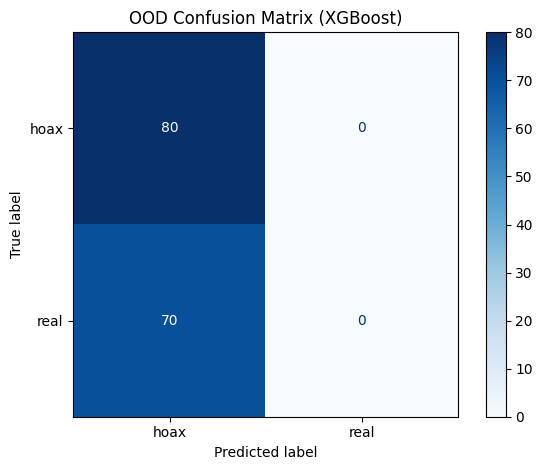

In [4]:
# test_bow_xgb_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# load the saved XGBoost pipeline
with open("xgb_bow_aug_hoax.pkl", "rb") as f:
    data          = pickle.load(f)
    xgb_model     = data["model"]
    vectorizer    = data["vectorizer"]
    stops         = data["stopwords"]
    label_encoder = data["label_encoder"]

# cleaning and tokenization function
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return tokens

# load the synthetic OOD dataset (tab-separated title, body, label)
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# preprocess and join title + body
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# vectorize into BOW features
X_syn = vectorizer.transform(texts).toarray()

# predict and decode numeric labels back to strings
preds_numeric = xgb_model.predict(X_syn)
preds = label_encoder.inverse_transform(preds_numeric)

# print accuracy and classification report
print("OOD Results for XGBoost")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# plot confusion matrix
cm = confusion_matrix(true_labels, preds, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("OOD Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()
